In [1]:
# Import necessary libraries
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import Dict, Tuple

In [2]:
# Ground-truth function
def f_true(x: torch.Tensor) -> torch.Tensor:
    # x: [N, 1]
    return torch.cos(2*math.pi*x) * (x**3)

In [3]:
# Generate synthetic data
def make_data(xmin=-3, xmax=3, n_train=256, n_eval=800, device=None):
    x_train = torch.linspace(xmin, xmax, n_train).unsqueeze(1)
    y_train = f_true(x_train)
    x_eval = torch.linspace(xmin, xmax, n_eval).unsqueeze(1)
    y_eval_true = f_true(x_eval).detach()
    if device:
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_eval = x_eval.to(device)
        y_eval_true = y_eval_true.to(device)
    return x_train, y_train, x_eval, y_eval_true

In [4]:
# Model 1 - Shallow Network
class Model1(nn.Module):
    # Model 1 with 1 hidden layer. Total params = 748
    def __init__(self, hidden=249):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

In [5]:
class Model2(nn.Module):
    # Model 2 with 3 hidden layers. Total params = 747
    def __init__(self, width1=18, width2=20, width3=15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, width1),
            nn.Tanh(),
            nn.Linear(width1, width2),
            nn.Tanh(),
            nn.Linear(width2, width3),
            nn.Tanh(),
            nn.Linear(width3, 1)
        )
    def forward(self, x): return self.net(x)

In [6]:
class Model3(nn.Module):
    # Mdel 3 with 5 hidden layers. Total params = 742 
    def __init__(self, width1=5, width2=10, width3=20, width4=15, width5=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, width1),
            nn.Tanh(),
            nn.Linear(width1, width2),
            nn.Tanh(),
            nn.Linear(width2, width3),
            nn.Tanh(),
            nn.Linear(width3, width4),
            nn.Tanh(),
            nn.Linear(width4, width5),
            nn.Tanh(),
            nn.Linear(width5, 1)
        )
    def forward(self, x): return self.net(x)

In [7]:
# Training loop
def train_model(
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epochs: int = 1200,
    lr: float = 1e-3,
    batch_size: int = 64
) -> Tuple[list, nn.Module]:
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr) # using Adam optimizer
    loss_fn = nn.MSELoss() # using MSE as the loss function
    loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x, y),
        batch_size=batch_size,
        shuffle=True,
        drop_last=False
    )
    losses = []
    for ep in range(epochs):
        total = 0.0
        for xb, yb in loader:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
        losses.append(total / len(loader.dataset))
    return losses, model

In [8]:
# Main function
def main():
    torch.manual_seed(42)
    np.random.seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Data
    x_train, y_train, x_eval, y_eval_true = make_data(device=device)

    # Models (two equal-param + one bonus)
    models: Dict[str, nn.Module] = {
        "Shallow model": Model1().to(device),
        "Deep model with 3 hidden layers": Model2().to(device),
        "Deep model with 5 hidden layers": Model3().to(device),
    }

    # Train
    EPOCHS = 20000     
    LR = 1e-3
    BATCH = 64

    loss_history = {}
    trained_models = {}
    for name, model in models.items():
        losses, trained = train_model(model, x_train, y_train, epochs=EPOCHS, lr=LR, batch_size=BATCH)
        loss_history[name] = losses
        trained_models[name] = trained

    # Plot training loss curve
    plt.figure(figsize=(7,5))
    for name, losses in loss_history.items():
        plt.plot(range(1, EPOCHS+1), losses, label=name, linewidth=1)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Epochs")
    plt.legend()
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.savefig("HW_1-1-DeepVsShallow/Func1/loss_curves.png", dpi=180)
    plt.show()

    # Plot Predictions vs Ground Truth
    plt.figure(figsize=(7,5))
    plt.plot(x_eval.detach().cpu().numpy(), y_eval_true.detach().cpu().numpy(),
             label="Ground Truth", linewidth=1)
    for name, model in trained_models.items():
        model.eval()
        with torch.no_grad():
            y_pred = model(x_eval).detach().cpu().numpy()
        plt.plot(x_eval.detach().cpu().numpy(), y_pred, label=name)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Function Approximation: Predictions vs Ground Truth")
    plt.legend()
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.savefig("HW_1-1-DeepVsShallow/Func1/predictions.png", dpi=180)
    plt.show()

Device: cuda


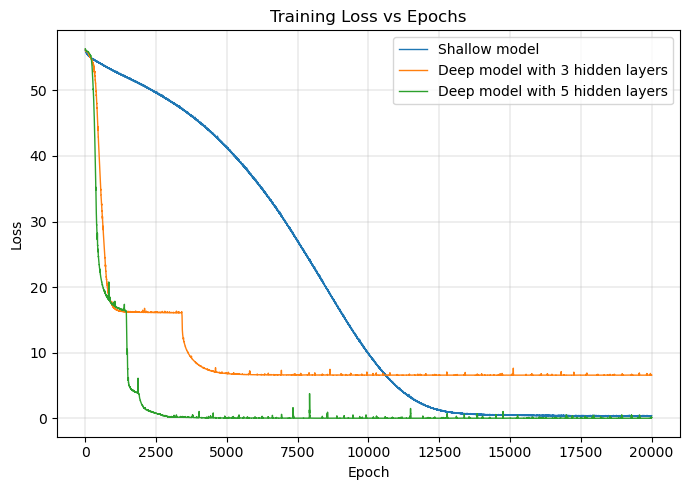

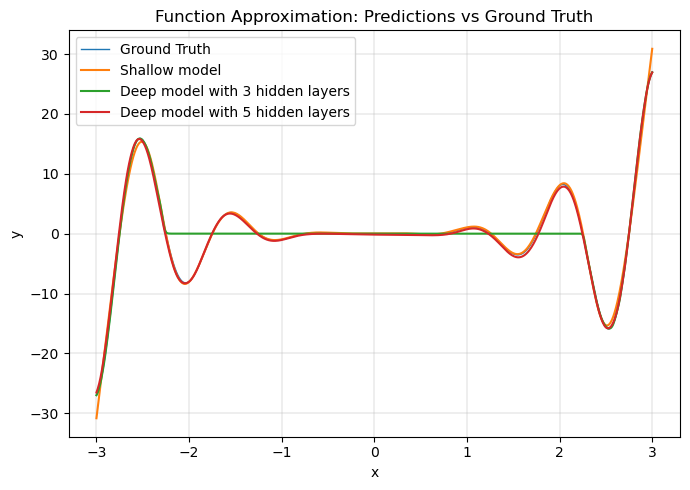

In [9]:
if __name__ == "__main__":
    main()